In [107]:
import pandas as pd

In [108]:
vul_data = pd.read_csv("./../vulnerability/npm_vul_data_before_2019_last_100.csv",delimiter=",")
vul_data

,Denial of Service in http-proxy-agent,http-proxy-agent,>=0 <2.1.0,2019-06-11T16:16:07Z,158021
0,Rate Limiting Bypass in express-brute,express-brute,>=0,2019-06-07T21:01:53Z,146016
1,express-basic-auth Timing Attack due to native...,express-basic-auth,>=0 <1.1.7,2019-06-06T15:32:32Z,1727860
2,Command Injection in command-exists,command-exists,>=0 <1.2.4,2019-06-03T17:31:26Z,137198
3,Command Injection in opencv,opencv,>=0 <6.1.0,2019-06-04T20:11:44Z,178575
4,Prototype Pollution in lutils-merge,lutils-merge,>=0,2019-06-13T18:58:44Z,1206748
...,...,...,...,...,...
94,Cross-Site Scripting in serialize-javascript,serialize-javascript,>=0 <2.1.1,2019-12-05T18:44:37Z,312181
95,Malicious Package in lodahs,lodahs,>=0.0.1,2019-12-16T19:29:33Z,3784246
96,Arbitrary File Write in npm,npm,>=0 <6.13.3,2019-12-13T15:39:19Z,177357
97,Validation bypass is possible in Json Pattern ...,jpv,>=0 <2.1.1,2019-12-04T21:25:28Z,2705971


In [109]:
vul_data.groupby(["Denial of Service in http-proxy-agent","http-proxy-agent" , "158021"]).size()

Denial of Service in http-proxy-agent                                                                        http-proxy-agent        158021 
Arbitrary Code Execution in eslint-utils                                                                     eslint-utils            2775836    1
Arbitrary Code Injection in mobile-icon-resizer                                                              mobile-icon-resizer     171065     1
Arbitrary File Read in html-pdf                                                                              html-pdf                157800     1
Arbitrary File Write in iobroker.js-controller                                                               iobroker.js-controller  160267     1
Arbitrary File Write in npm                                                                                  npm                     177357     1
                                                                                                                                 

In [110]:
vul_data = pd.read_csv("./affected_packages_npm_with_all.csv",delimiter=",")

In [111]:
vul_data.groupby("vul_project_id").size()

vul_project_id
127732     4667
131707      309
132522       92
133746       18
135900     1751
           ... 
3229321       7
3258308       9
3500303       6
3655233       1
4433945       1
Length: 82, dtype: int64

In [112]:
vul_data["vul_months"] = (vul_data["vul_end_timestamp"] - vul_data["vul_start_timestamp"]) / (3600 * 24 * 30)

In [114]:
vul_data.query('compliantType == 2 and vul_end_timestamp < 1674091000').loc[:,["project_id", "vul_project_id","vul_start_datetime","vul_end_datetime", "vul_start_dependency_compliant","vul_months", 'compliantType']]

,project_id,vul_project_id,vul_start_datetime,vul_end_datetime,vul_start_dependency_compliant,vul_months,compliantType
6,142998,177357,2014-10-19 23:03:01 +0000 UTC,2019-12-10 01:31:48 +0000 UTC,*,62.570111,2
25,174533,177357,2014-09-18 19:15:54 +0000 UTC,2019-12-10 01:31:48 +0000 UTC,*,63.608701,2
51,126339,177357,2014-01-23 01:28:19 +0000 UTC,2019-12-10 01:31:48 +0000 UTC,*,71.566747,2
52,126623,177357,2013-11-27 13:33:23 +0000 UTC,2019-12-10 01:31:48 +0000 UTC,*,73.449963,2
55,126736,177357,2014-07-03 13:35:32 +0000 UTC,2019-12-10 01:31:48 +0000 UTC,*,66.183247,2
...,...,...,...,...,...,...,...
70488,2664606,137198,2018-02-16 19:01:08 +0000 UTC,2018-04-12 23:17:57 +0000 UTC,*,1.839278,2
70603,3307771,1727860,2018-11-07 19:17:03 +0000 UTC,2019-04-22 21:37:27 +0000 UTC,>=1.1.5,5.536583,2
70688,1307895,158021,2016-03-30 06:33:14 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,*,23.457325,2
70689,1310517,158021,2016-03-30 07:12:37 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,*,23.456413,2


<AxesSubplot: >

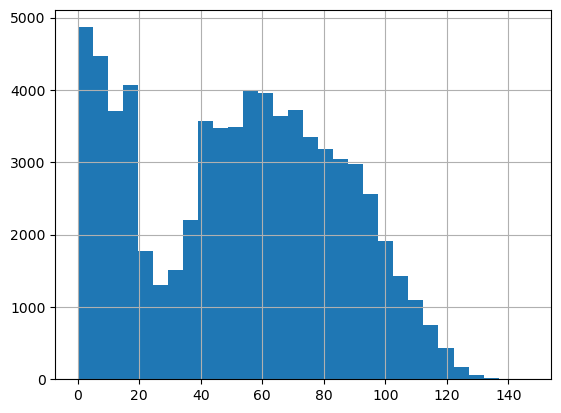

In [115]:
vul_data["vul_months"].hist(bins=30)

In [116]:
vul_data.groupby("compliantType").size()

compliantType
1    51279
2     2533
3    11609
4      648
5     4665
dtype: int64

# サバイバル分析

In [117]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

In [118]:
vul_data_compliant = vul_data[vul_data["compliantType"] == 1]
vul_data_permissive = vul_data[vul_data["compliantType"] == 2]
vul_data_restrictive = vul_data[vul_data["compliantType"] == 3]

In [119]:
status = vul_data["vul_end_timestamp"] < 1674091000

In [120]:
status

0        False
1        False
2        False
3        False
4        False
         ...  
70729     True
70730     True
70731     True
70732    False
70733    False
Name: vul_end_timestamp, Length: 70734, dtype: bool

In [126]:
vul_data_compliant["vul_months"].describe()

count    51279.000000
mean        47.166594
std         30.704175
min          0.000020
25%         16.502728
50%         48.881564
75%         72.481952
max        126.018718
Name: vul_months, dtype: float64

In [127]:
vul_data_permissive["vul_months"].describe()

count    2533.000000
mean       45.057231
std        31.307187
min         0.027702
25%        20.087608
50%        38.582799
75%        65.238924
max       140.122453
Name: vul_months, dtype: float64

In [128]:
vul_data_restrictive["vul_months"].describe()

count    11609.000000
mean        77.681767
std         27.887782
min          0.000033
25%         57.745978
50%         80.624334
75%        101.025946
max        135.791378
Name: vul_months, dtype: float64

Text(0.5, 0, 'time $t$')

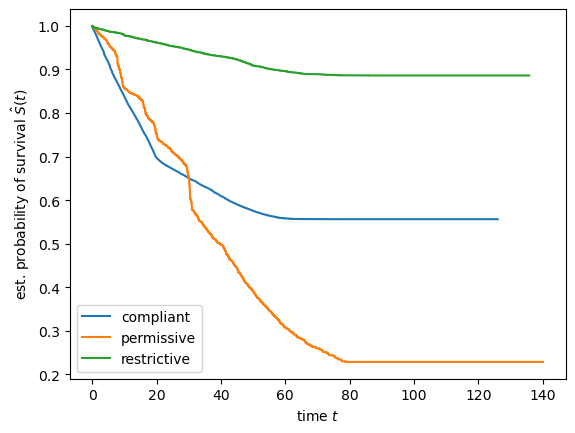

In [121]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant["vul_end_timestamp"] < 1674091000, vul_data_compliant["vul_months"])
time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive["vul_end_timestamp"] < 1674091000, vul_data_permissive["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive["vul_end_timestamp"] < 1674091000, vul_data_restrictive["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## 生存分析(打ち切りなしver)

Text(0.5, 0, 'time $t$')

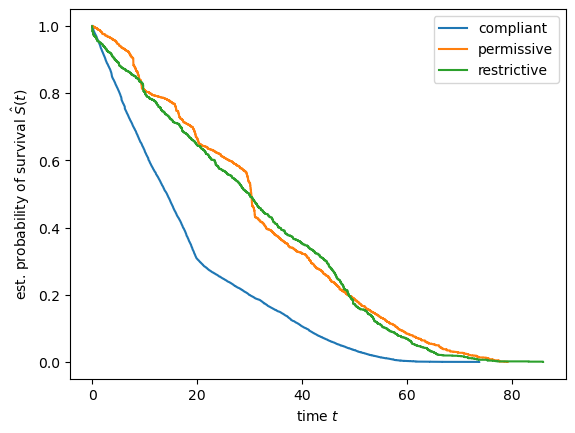

In [129]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"])

time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

<AxesSubplot: >

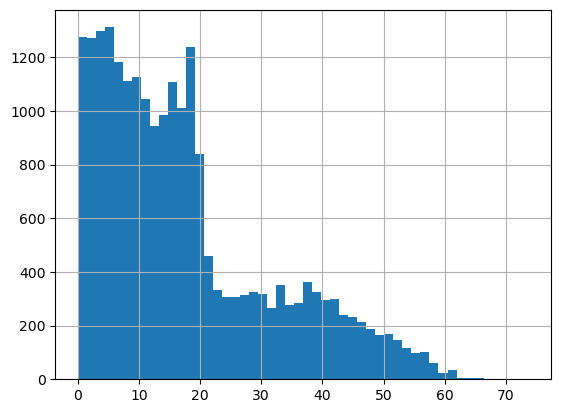

In [130]:
vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=50)

<AxesSubplot: >

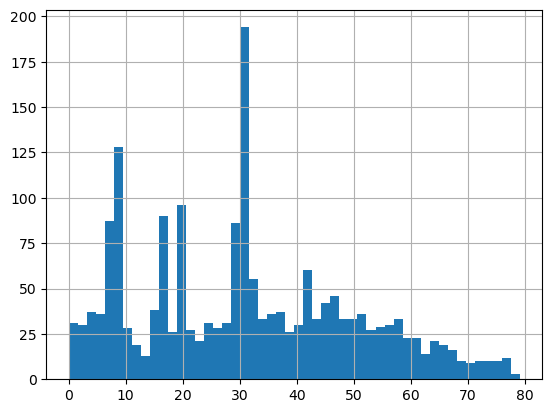

In [131]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=50)

<AxesSubplot: >

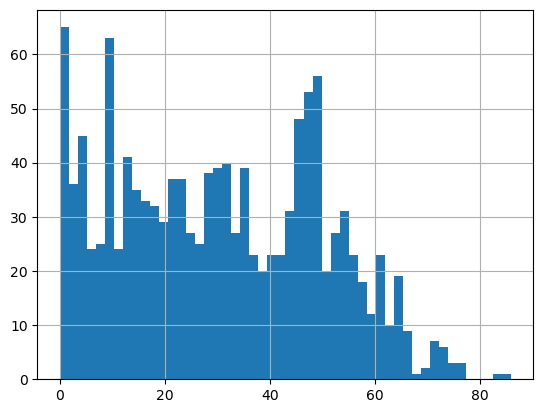

In [132]:
vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=50)

In [134]:
vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count    22373.000000
mean        17.632812
std         14.273616
min          0.000020
25%          6.334007
50%         14.231697
75%         24.695568
max         73.701899
Name: vul_months, dtype: float64

In [135]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count    1876.000000
mean       31.281488
std        18.893467
min         0.027702
25%        16.023991
50%        30.286425
75%        45.078389
max        79.104765
Name: vul_months, dtype: float64

In [136]:
vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count    1254.000000
mean       30.380582
std        19.359744
min         0.000033
25%        13.191301
50%        29.851510
75%        46.575552
max        85.856696
Name: vul_months, dtype: float64

In [138]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000].groupby("vul_project_id").size()

vul_project_id
127732     276
131707       6
132522       3
135900     107
137198       3
137649      18
138017       5
141005       2
158021       3
160277       3
160443       1
177357     405
178575       5
179859       3
272771     337
273575      48
276738      25
277678      68
278126       5
282914     172
288506      17
294767       3
295772      17
299787      15
301010       9
301758       4
303609       3
310306       1
311863       7
312067       3
312181      11
320164       4
326672     190
333360       2
736965       2
811460      88
1589520      2
1727860      1
2775836      2
dtype: int64

In [144]:
vul_data_permissive.query("vul_end_timestamp < 1674091000 and vul_project_id == 127732")

,project_id,vul_project_id,vul_start_datetime,vul_end_datetime,vul_start_timestamp,vul_end_timestamp,compliantType,vul_start_dependency_compliant,vul_start_version,vul_deps,vul_total_count,vul_months
18698,606071,127732,2015-02-17 11:47:56 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1424173676,1574155803,2,>=1.2.19,1.3.13,0,1,57.863475
18702,262468,127732,2015-02-06 01:28:23 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1423186103,1574155803,2,*,1.3.12,0,1,58.244483
18706,174084,127732,2015-01-20 06:25:01 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1421735101,1574155803,2,*,1.3.9,0,1,58.804283
18709,633368,127732,2015-02-18 23:13:42 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1424301222,1574155803,2,*,1.3.13,0,1,57.814267
18719,127812,127732,2014-10-13 08:41:58 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1413189718,1574155803,2,*,1.2.23,0,1,62.101113
...,...,...,...,...,...,...,...,...,...,...,...,...
23210,1088625,127732,2019-05-23 15:00:46 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1558623646,1574155803,2,>=1.0,1.7.8,0,1,5.992345
23221,4052928,127732,2019-05-29 13:13:24 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1559135604,1574155803,2,*,1.7.8,0,1,5.794830
23262,4262964,127732,2019-07-25 15:19:29 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1564067969,1574155803,2,>=1.4.0,1.7.8,0,1,3.891911
23318,4468884,127732,2019-09-27 21:38:10 +0000 UTC,2019-11-19 09:30:03 +0000 UTC,1569620290,1574155803,2,*,1.7.8,0,1,1.749812
